## Implementacja "Robust global stabilization and disturbance rejection of an underactuated nonholonomic airship"

Link do implementowanego artykułu: https://ieeexplore.ieee.org/document/4389345

# Import

In [3]:
import sympy as sp
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt # ploting results
from scipy.integrate import solve_ivp # solving differential equations
MAT = np.array

# Definicja zmiennych

In [4]:
t = sp.symbols('t') # czas
th = sp.symbols('\\theta') # kąt obrotu sterowca w układzie globalnym
u = sp.symbols('u') # prędkość wzdłużna sterowca w układzie lokalnym
v = sp.symbols('v') # prędkość poprzeczna sterowca w układzie lokalnym
r = sp.symbols('r') # prędkość obrotowa sterowca w układzie globalnym
x, y = sp.symbols('x y') # położenie sterowca w układzie globalnym
z1, z2, z3 = sp.symbols('z_{1} z_{2} z_{3}') # ?
tauu, taur = sp.symbols('\\tau_{u} \\tau_{r}') # sygnały sterujące kolejno: siła ciągu, siła skręcająca 
ub, vb, z1b, z2b, z3b = sp.symbols('\\bar{u} \\bar{v} \\bar{z}_{1} \\bar{z}_{2} \\bar{z}_{3}')#nowe zmienne stanu po transforma

# Współczynniki

In [5]:
Cu, Cv, Cr = sp.symbols('C_{u} C_{v} C_{r}') #współczynniki aerodynamiczne względem osi u v r
Vw = sp.symbols('V_{w}') #prędkość wiatru (w artykule jest zawsze stała)
a_ship, b_ship = sp.symbols('a_{ship} b_{ship}') #długość sterowca, szerokość sterowca
m, m3 = sp.symbols('m m_{3}') # masa strowca m=m1=m2, masa sterowca m3
d1_sym, d2_sym, d3_sym = sp.symbols('d_{1} d_{2} d_{3}') # współczynniki tłumienia kolejno w osi u v r
d1f, d2f, d3f, th3f_sym = sp.symbols('\\underline{d}_{1} \\underline{d}_{2} \\underline{d}_{3} \\underline{\\theta}_{3}') # dolne wartości wsp tłumienia d1, d2, d3
d1c, d2c, d3c, th3c_sym = sp.symbols('\\bar{d}_{1} \\bar{d}_{2} \\bar{d}_{3} \\bar{\\theta}_{3}') # górne wartości współczynników tłumienia d1, d2, d3
d10_sym, d20_sym, d30_sym, th30_sym = sp.symbols('d_{10} d_{20} d_{30} \\theta_{30}') # niepewności
Delta_1_sym, Delta_2_sym, Delta_3_sym, delta_1_sym, delta_2_sym, delta_3_sym = sp.symbols('\\Delta_{1} \\Delta_{2} \\Delta_{3} \\delta_{1} \\delta_{2} \\delta_{3}')# niepewności
k1, k2, k3, a = sp.symbols('k_{1} k_{2} k_{3} a') # współczynniki wzmocnień syg ster tau_r
k_th_sym, k_r_sym  = sp.symbols('k_{\\theta} k_{r}') # jak wyżej
k1b, k2b, k3b, k4b, k5b = sp.symbols('\\bar{k}_{1} \\bar{k}_{2} \\bar{k}_{3} \\bar{k}_{4} \\bar{k}_{5}')#wsp wzm sterownika tau_u
th_1_sym, th_2_sym, th_3_sym = sp.symbols('\\theta_1 \\theta_2 \\theta_3') # współczynniki th z obliczone na podst wzoru 4.4
lam_1_sym, lam_2_sym = sp.symbols('\lambda_1 \lambda_2') # współczynniki lam z obliczone na podst wzoru 4.4
delta_d_sym = sp.symbols('\\Delta_{d}') # współczynnik deltad ze wzoru 4.3
th_0, r_0 = sp.symbols('th(0) r(0)')# wartości początkowe
fus, fvs, frs = sp.symbols('f_{u} f_{v} f_{r}') # funkcje symboliczne

Definicja funkcji - rozdział II (2.2)

In [6]:
F_sym = sp.sqrt(a_ship**2 * sp.sin(th)**2 + b_ship**2 * sp.cos(th)**2)
F = sp.symbols('F(\\theta)')
display(F_sym)

sqrt(a_{ship}**2*sin(\theta)**2 + b_{ship}**2*cos(\theta)**2)

Definicja funkcji - rozdział II (2.2)

In [7]:
fu_sym = Cu * Vw**2 * F * sp.cos(th)
fv_sym = Cv * Vw**2 * F * sp.sin(th)
fr_sym = Cr * Vw**2 * F * sp.cos(2 * th)
display(fu_sym,fv_sym,fr_sym)
fu_sym = Cu * Vw**2 * F_sym * sp.cos(th)
fv_sym = Cv * Vw**2 * F_sym * sp.sin(th)
fr_sym = Cr * Vw**2 * F_sym * sp.cos(2 * th)
#display(fu_sym,fv_sym,fr_sym) #po podstawieniu F(th)

C_{u}*F(\theta)*V_{w}**2*cos(\theta)

C_{v}*F(\theta)*V_{w}**2*sin(\theta)

C_{r}*F(\theta)*V_{w}**2*cos(2*\theta)

Opis modelu kinematycznego, geometrycznego powiązania pomiędzy układem globalnym a układem lokalnym - rozdział II (2.4)

In [8]:
dx_sym = u * sp.cos(th) - v * sp.sin(th)
dy_sym = u * sp.sin(th) + v * sp.cos(th)
dth_sym = r
display(dx_sym,dy_sym,dth_sym)

u*cos(\theta) - v*sin(\theta)

u*sin(\theta) + v*cos(\theta)

r

Ciąg dalszy opisu kinematyki, z1 z2 - rozdział II (2.5)

In [9]:
z1_sym = x * sp.cos(th) + y * sp.sin(th)
z2_sym = -x * sp.sin(th) + y * sp.cos(th)
#wyświetlanie implementowanych wzorów
display(z1_sym,z2_sym)

x*cos(\theta) + y*sin(\theta)

-x*sin(\theta) + y*cos(\theta)

Równanie stanu uzyskane przez połączenie kinematyki i dynamiki sterowca - rozdział II (2.6)

In [10]:
# układ Sigma1:
# macierz stanu
A1_sym = sp.Matrix([[-d1_sym,r,0,0],[-r,-d2_sym,0,0],[1,0,0,r],[0,1,-r,0]]) 
#---------
q_sym = sp.Matrix([[u,v,z1,z2]]).T # wektor stanu
b1_sym = sp.Matrix([[1/m,0,0,0]]).T # macierz sterowania
# wektor sił zakłóceń - wiatru
f1_sym = sp.Matrix([[fus/m,fvs/m,0,0]]).T 
#system dynamiczny
#dQ1 = A1_sym @ q_sym + b1_sym * tauu + f1_sym #wpisać w funkcji symulacji
#wyświetlanie implementowanych wzorów
display(A1_sym,q_sym,b1_sym,f1_sym)

Matrix([
[-d_{1},      r,  0, 0],
[    -r, -d_{2},  0, 0],
[     1,      0,  0, r],
[     0,      1, -r, 0]])

Matrix([
[    u],
[    v],
[z_{1}],
[z_{2}]])

Matrix([
[1/m],
[  0],
[  0],
[  0]])

Matrix([
[f_{u}/m],
[f_{v}/m],
[      0],
[      0]])

In [11]:
# układ Sigma2:                                    #ten układ umieścić w funkcji symulacji
dr_sym = -d3_sym * r + (1/m3) * (taur + frs) 
dth_sym = r
display(dr_sym,dth_sym)

-d_{3}*r + (\tau_{r} + f_{r})/m_{3}

r

Sygnał sterujący dla podsystemu Sigma2 - rozdział IV (4.1)

In [12]:
taur_sym = m3 * (-k_r_sym * r - k_th_sym * th + a * sp.exp(-k3 * t) - frs) 
display(taur_sym)

m_{3}*(-\theta*k_{\theta} + a*exp(-k_{3}*t) - f_{r} - k_{r}*r)

Odpowiedź kąta i prędkości kątowej jest dana - rozdział IV (4.3)

In [13]:
theta_sym = th_1_sym*sp.exp(-lam_1_sym*t) + th_2_sym*sp.exp(-lam_2_sym*t) + th_3_sym*sp.exp(-k3*t) # th(t)
r_sym = -th_1_sym*lam_1_sym*sp.exp(-lam_1_sym*t) - th_2_sym*lam_2_sym*sp.exp(-lam_2_sym*t) - th_3_sym*k3*sp.exp(-k3*t) # r(t)
tta, rf = sp.symbols('\\theta(t) r(t)') # to będą później funkcje te powyżej
display(theta_sym,r_sym)

\theta_1*exp(-\lambda_1*t) + \theta_2*exp(-\lambda_2*t) + \theta_3*exp(-k_{3}*t)

-\lambda_1*\theta_1*exp(-\lambda_1*t) - \lambda_2*\theta_2*exp(-\lambda_2*t) - \theta_3*k_{3}*exp(-k_{3}*t)

Funkcja alpha(t) - rozdział IV (4.14)

In [14]:
Alp_sym = -(th_1_sym*lam_1_sym*sp.exp(-(lam_1_sym-k3)*t)+th_2_sym*lam_2_sym*sp.exp(-(lam_2_sym-k3)*t)) #funkcja alpha(t)
display(Alp_sym)

-\lambda_1*\theta_1*exp(t*(-\lambda_1 + k_{3})) - \lambda_2*\theta_2*exp(t*(-\lambda_2 + k_{3}))

Implementacja współczynników theta - rozdział IV (4.4)

In [15]:
th_1_sym2 = ((lam_2_sym*th_0 + r_0)/(lam_2_sym - lam_1_sym)) + a/((lam_2_sym - lam_1_sym)*(k3 - lam_1_sym))
th_2_sym2 = ((k1*th_0 + r_0)/(lam_1_sym - lam_2_sym)) + a/((lam_1_sym - lam_2_sym)*(k3 - lam_2_sym))
th_3_sym2 = a/((lam_1_sym - k3)*(lam_2_sym - k3))
#wyświetlanie implementowanych wzorów
display(th_1_sym2,th_2_sym2,th_3_sym2)  

a/((-\lambda_1 + \lambda_2)*(-\lambda_1 + k_{3})) + (\lambda_2*th(0) + r(0))/(-\lambda_1 + \lambda_2)

a/((\lambda_1 - \lambda_2)*(-\lambda_2 + k_{3})) + (k_{1}*th(0) + r(0))/(\lambda_1 - \lambda_2)

a/((\lambda_1 - k_{3})*(\lambda_2 - k_{3}))

Implementacja współczynników lambda - rozdział IV (4.4)

In [16]:
lam_1_sym2 = ((delta_d_sym + k1 + k2) + sp.sqrt(delta_d_sym**2 + 2*delta_d_sym*(k1 + k2) + (k1 - k2)**2))/2#
lam_2_sym2 = ((delta_d_sym + k1 + k2) - sp.sqrt(delta_d_sym**2 + 2*delta_d_sym*(k1 + k2) + (k1 - k2)**2))/2#
delta_d_sym2 = d3_sym - d3f#
#wyświetlanie implementowanych wzorów
display(lam_1_sym2,lam_2_sym2,delta_d_sym2)

\Delta_{d}/2 + k_{1}/2 + k_{2}/2 + sqrt(\Delta_{d}**2 + 2*\Delta_{d}*(k_{1} + k_{2}) + (k_{1} - k_{2})**2)/2

\Delta_{d}/2 + k_{1}/2 + k_{2}/2 - sqrt(\Delta_{d}**2 + 2*\Delta_{d}*(k_{1} + k_{2}) + (k_{1} - k_{2})**2)/2

-\underline{d}_{3} + d_{3}

Implementacja systemu Sigma1e - rozdział IV (4.7)

In [17]:
A2_sym = sp.Matrix([[-d1_sym,rf,0,0,0],[-rf,-d2_sym,0,0,0],[1,0,0,rf,0],[0,1,-rf,0,0],[0,0,1,0,0]])# macierz stanu
b2_sym = sp.Matrix([[1/m,0,0,0,0]]).T # macierz sterowania
ff_sym = sp.Matrix([[fus/m,-fvs/m,0,0,0]]).T # wektor zakłóceń - wiatru
q2_sym = sp.Matrix([[u,v,z1,z2,z3]]).T # wektor stanu
#dX1_sym = A2_sym @ q2_sym + b2_sym * tauu + ff_sym    # to dać w funkcji symulacji
display(A2_sym,b2_sym,ff_sym,q2_sym)
#display(dX1_sym)

Matrix([
[-d_{1},   r(t),     0,    0, 0],
[ -r(t), -d_{2},     0,    0, 0],
[     1,      0,     0, r(t), 0],
[     0,      1, -r(t),    0, 0],
[     0,      0,     1,    0, 0]])

Matrix([
[1/m],
[  0],
[  0],
[  0],
[  0]])

Matrix([
[ f_{u}/m],
[-f_{v}/m],
[       0],
[       0],
[       0]])

Matrix([
[    u],
[    v],
[z_{1}],
[z_{2}],
[z_{3}]])

Nowy wektor stanu - rozdział IV (4.10)

In [18]:
ub = u
vb = v * sp.exp(k3 * t)
z1b = z1
z2b = z2 * sp.exp(k3 * t)
z3b = z3
Xb = sp.Matrix([[ub,vb,z1b,z2b,z3b]]).T
#wyświetlanie implementowanych wzorów
#display(Xb)

Współczynniki d1, d2, th3 - rozdział IV (4.11)

In [19]:
d1_sym2 = d10_sym + Delta_1_sym#
d2_sym2 = d20_sym + Delta_2_sym#
d3_sym2 = d30_sym + Delta_3_sym# za d3 podstawić ręcznie wartość z artykułu 0.05
th3_sym2 = th30_sym + Delta_3_sym#
#wyświetlanie implementowanych wzorów
display(d1_sym2,d2_sym2,d3_sym2,th3_sym2)

\Delta_{1} + d_{10}

\Delta_{2} + d_{20}

\Delta_{3} + d_{30}

\Delta_{3} + \theta_{30}

Rozszerzony system Sigma1e bez zakłócenia f(t) - rozdział IV (4.13) i (4.14)

In [20]:
#macierze o stałych współczynnikach
A10_sym = sp.Matrix([[-d10_sym,0,0,0,0],[th30_sym*k3,-(d20_sym-k3),0,0,0],[1,0,0,0,0],[0,1,th30_sym*k3,k3,0],[0,0,1,0,0]])#
D_sym = sp.Matrix([[1,0,0,0],[0,1,1,0],[0,0,0,0],[0,0,0,1],[0,0,0,0]])#
E_sym = sp.Matrix([[-delta_1_sym,0,0,0,0],[0,-delta_2_sym,0,0,0],[k3*delta_3_sym,0,0,0,0],[0,0,k3*delta_3_sym,0,0]])#
DELTA_sym = sp.Matrix.diag([Delta_1_sym/delta_1_sym,Delta_2_sym/delta_2_sym,Delta_3_sym/delta_3_sym,Delta_3_sym/delta_3_sym])#
#macierz o zmiennych współczynnikach
af = sp.symbols('\\alpha(t)')# to będzie później funkcja alpha(t)
A22_sym = sp.Matrix([[0,rf*sp.exp(-k3*t),0,0,0],[af,0,0,0,0],[0,0,0,rf*sp.exp(-k3*t),0],[0,0,af,0,0],[0,0,0,0,0]])
#wyświetlanie implementowanych wzorów
display(A22_sym)
display(A10_sym,D_sym,E_sym,DELTA_sym)

Matrix([
[        0, r(t)*exp(-k_{3}*t),         0,                  0, 0],
[\alpha(t),                  0,         0,                  0, 0],
[        0,                  0,         0, r(t)*exp(-k_{3}*t), 0],
[        0,                  0, \alpha(t),                  0, 0],
[        0,                  0,         0,                  0, 0]])

Matrix([
[          -d_{10},               0,                 0,     0, 0],
[\theta_{30}*k_{3}, -d_{20} + k_{3},                 0,     0, 0],
[                1,               0,                 0,     0, 0],
[                0,               1, \theta_{30}*k_{3}, k_{3}, 0],
[                0,               0,                 1,     0, 0]])

Matrix([
[1, 0, 0, 0],
[0, 1, 1, 0],
[0, 0, 0, 0],
[0, 0, 0, 1],
[0, 0, 0, 0]])

Matrix([
[     -\delta_{1},           0,                0, 0, 0],
[               0, -\delta_{2},                0, 0, 0],
[\delta_{3}*k_{3},           0,                0, 0, 0],
[               0,           0, \delta_{3}*k_{3}, 0, 0]])

Matrix([
[\Delta_{1}/\delta_{1},                     0,                     0,                     0],
[                    0, \Delta_{2}/\delta_{2},                     0,                     0],
[                    0,                     0, \Delta_{3}/\delta_{3},                     0],
[                    0,                     0,                     0, \Delta_{3}/\delta_{3}]])

Wzory potrzebne do obliczenia d1, d2, th3 - rozdział IV (4.12)

In [21]:
delta_3_sym2 = (th3c_sym - th3f_sym)/2#
th30_sym2 = (th3c_sym + th3f_sym)/2#
display(delta_3_sym2,th30_sym2)

\bar{\theta}_{3}/2 - \underline{\theta}_{3}/2

\bar{\theta}_{3}/2 + \underline{\theta}_{3}/2

In [22]:
th3f_sym2 = a/((k3 - k1)*(k3 - k2))#
th3c_sym2 = a/(k3**2 - (d3c + k_r_sym)*k3 + k1*k2)#
d10_sym2 = (d1c + d1f)/2#
d20_sym2 = (d2c + d2f)/2#
d30_sym2 = (d3c + d3f)/2#
delta_1_sym2 = (d1c - d1f)/2#
delta_2_sym2 = (d2c - d2f)/2#
#wyświetlanie implementowanych wzorów
display(th3f_sym2,th3c_sym2,d10_sym2,d20_sym2,d30_sym2,delta_1_sym2,delta_2_sym2)

a/((-k_{1} + k_{3})*(-k_{2} + k_{3}))

a/(k_{1}*k_{2} + k_{3}**2 - k_{3}*(\bar{d}_{3} + k_{r}))

\bar{d}_{1}/2 + \underline{d}_{1}/2

\bar{d}_{2}/2 + \underline{d}_{2}/2

\bar{d}_{3}/2 + \underline{d}_{3}/2

\bar{d}_{1}/2 - \underline{d}_{1}/2

\bar{d}_{2}/2 - \underline{d}_{2}/2

Sygnał sterujący tau_u - rozdział IV (4.21)

In [23]:
tauu_sym = -(k1b*u+k2b*v*sp.exp(k3*t)+k3b*z1+k4b*z2*sp.exp(k3*t)+k5b*z3)
#wyświetlanie implementowanych wzorów
display(tauu_sym)

-\bar{k}_{1}*u - \bar{k}_{2}*v*exp(k_{3}*t) - \bar{k}_{3}*z_{1} - \bar{k}_{4}*z_{2}*exp(k_{3}*t) - \bar{k}_{5}*z_{3}

Wektor zakłóceń - rozdział IV (4.26)

In [24]:
#wektor zakłóceń
fb_sym = sp.Matrix([[Cu*Vw**2*F*sp.cos(tta)/m,-Cv*Vw**2*sp.exp(k3*t)*F*sp.sin(tta)/m,0,0,0]]).T 
display(fb_sym)  

Matrix([
[              C_{u}*F(\theta)*V_{w}**2*cos(\theta(t))/m],
[-C_{v}*F(\theta)*V_{w}**2*exp(k_{3}*t)*sin(\theta(t))/m],
[                                                      0],
[                                                      0],
[                                                      0]])

Wzory na współczynniki sterownika tau_r

In [25]:
k_th_sym2 = k1 * k2#
k_r_sym2 = k1 + k2 - d3f#
display(k_th_sym2,k_r_sym2)

k_{1}*k_{2}

-\underline{d}_{3} + k_{1} + k_{2}

Wzory na Delta_i - Delta_i <= delta_i - rozdział (4.11)

In [26]:
Delta_1_sym2 = delta_1_sym
Delta_2_sym2 = delta_2_sym
Delta_3_sym2 = delta_3_sym

Wektor wzmocnień sterownika - rozdział IV (4.21)

In [27]:
Kb_sym2 = sp.Matrix([[k1b,k2b,k3b,k4b,k5b]])
display(Kb_sym2)

Matrix([[\bar{k}_{1}, \bar{k}_{2}, \bar{k}_{3}, \bar{k}_{4}, \bar{k}_{5}]])

## ----------------------------------------------------------------------------------------------------------------------------------

# Podstawienie wartości do zmiennych symbolicznych

In [28]:
params = {a_ship:1.2,b_ship:0.5} #Podstawienie wymiarów sterowca
params.update({Cu:0.42,Cv:0.42,Cr:0.42,Vw:0.1}) #Podstawienie wartości współczynników aerodynamicznych i prędkości wiatru
params.update({m:0.072, m3:0.018})#Podstawienie wartości masy strowca m=m1=m2, masa sterowca m3
params.update({d1f:0.008, d2f:0.029, d3f:0.035})#Podstawienie dolnych wartości współczynników tłumienia
params.update({d1c:0.01, d2c:0.057, d3c:0.05})#Podstawienie górnych wartości współczynników tłumienia
params.update({k1:0.52, k2:0.5, k3:0.35, a:0.15})#Podstawienie wartości wzmocnień kontrolera tau_r
params.update({k1b:1.6, k2b:0.13, k3b:1.0, k4b:0.16, k5b:0.0032})#Podstawienie wartości
params.update({th_0:1,r_0:0})#Wartości początkowe kąta, prędkości kątowej

In [29]:
#podstawienie wartości stałych współczynników
tmp = sp.Matrix([[a_ship,b_ship,m,m3,Cu,Cv,Cr,Vw,d1f,d2f,d3f,d1c,d2c,d3c,k1,k2,k3,a,k1b,k2b,k3b,k4b,k5b]]).subs(params)
a_ship,b_ship,m,m3,Cu,Cv,Cr,Vw,d1f,d2f,d3f,d1c,d2c,d3c,k1,k2,k3,a,k1b,k2b,k3b,k4b,k5b = tmp
k_r_num = k_r_sym2.subs(params)
k_th_num = k_th_sym2.subs(params)
th3f_num = th3f_sym2.subs(params)
params.update({k_r_sym:k_r_num,k_th_sym:k_th_num,th3f_sym:th3f_num})
th3c_num = th3c_sym2.subs(params)
d10_num = d10_sym2.subs(params)
d20_num = d20_sym2.subs(params)
d30_num = d30_sym2.subs(params)
delta_1_num = delta_1_sym2.subs(params)
delta_2_num = delta_2_sym2.subs(params)
params.update({th3c_sym:th3c_num,d10_sym:d10_num,d20_sym:d20_num,d30_sym:d30_num})
params.update({delta_1_sym:delta_1_num,delta_2_sym:delta_2_num})
delta_3_num = delta_3_sym2.subs(params)
th30_num = th30_sym2.subs(params)
params.update({delta_3_sym:delta_3_num,th30_sym:th30_num})
Delta_1_num = Delta_1_sym2.subs(params)
Delta_2_num = Delta_2_sym2.subs(params)
Delta_3_num = Delta_3_sym2.subs(params)
params.update({Delta_1_sym:Delta_1_num,Delta_2_sym:Delta_2_num,Delta_3_sym:Delta_3_num})
d1_num = d1_sym2.subs(params)
d2_num = d2_sym2.subs(params) 
d3_num = 0.05 #d3_sym2.subs(params) 
params.update({d1_sym:d1_num,d2_sym:d2_num,d3_sym:d3_num})
delta_d_num = delta_d_sym2.subs(params)
params.update({delta_d_sym:delta_d_num})
lam_2_num = lam_2_sym2.subs(params)
lam_1_num = lam_1_sym2.subs(params)
params.update({lam_1_sym:lam_1_num,lam_2_sym:lam_2_num})
th_1_num = th_1_sym2.subs(params)
th_2_num = th_2_sym2.subs(params)
th_3_num = th_3_sym2.subs(params)
params.update({th_1_sym:th_1_num,th_2_sym:th_2_num,th_3_sym:th_3_num})
#macierze
A10_num = A10_sym.subs(params)
D_num = D_sym.subs(params)
E_num = E_sym.subs(params) 
DELTA_num = DELTA_sym.subs(params)
K_num = Kb_sym2.subs(params)
#wektory niezależne
b1_num = b1_sym.subs(params)
b2_num = b2_sym.subs(params)

# Definicja funkcji numerycznych

In [30]:
# Funkcje przyjmujące zmienną
F_num = sp.lambdify((th),F_sym.subs(params)) # F_num(th)
fu_num = sp.lambdify((th),fu_sym.subs(params)) # fu_num(th)
fv_num = sp.lambdify((th),fv_sym.subs(params)) # fv_num(th)
fr_num = sp.lambdify((th),fr_sym.subs(params)) # fr_num(th)
tauu_num = sp.lambdify((u,v,z1,z2,z3,t),tauu_sym.subs(params)) # tauu_num(u,v,z1,z2,z3,t)
taur_num = sp.lambdify((r,th,t,frs),taur_sym.subs(params)) # taur_num(r,th,t,fr_num(th))
alpha_num = sp.lambdify((t),Alp_sym.subs(params)) # alpha_num(t)
theta_num = sp.lambdify((t),theta_sym.subs(params)) # theta_num(t)
r_num = sp.lambdify((t),r_sym.subs(params)) # r_num(t)
fb_num = sp.lambdify((tta,F,t),fb_sym.subs(params)) # fb_num(theta_num(t),F_num(theta_num(t)),t)
ff_num = sp.lambdify((fus,fvs),ff_sym.subs(params)) # ff_num(fu_num(th),fv_num(th))
dx_num = sp.lambdify((u,v,th),dx_sym.subs(params)) # dx_num(u,v,th)
dy_num = sp.lambdify((u,v,th),dy_sym.subs(params)) # dy_num(u,v,th)
# macierze zmienne
A2_num = sp.lambdify((rf),A2_sym.subs(params)) # A2_num(r_num(t))
A22_num = sp.lambdify((rf,af,t),A22_sym.subs(params)) # A22_num(r_num(t),alpha_num(t),t)
# Układ Sigma 2
dth_num = sp.lambdify((r),dth_sym.subs(params)) # dth_num(r)
dr_num = sp.lambdify((r,taur,frs),dr_sym.subs(params)) # dr_num(r,taur,fr_num(th))
# Układ Sigma 1
f1_num = sp.lambdify((fus,fvs),f1_sym.subs(params)) # f1_num(fu_num(th),fv_num(th))
A1_num = sp.lambdify((r),A1_sym.subs(params)) # A1_num(r)
#---
Ac_num = A10_num - b2_num @ K_num + D_num @ DELTA_num @ E_num

# Definicja funkcji symulacji

In [40]:
def Blimp(t_, xi_array):
    xi = MAT([xi_array]).T
    ui = MAT(xi[0][0])
    vi = MAT(xi[1][0])
    z1i = MAT(xi[2][0])
    z2i = MAT(xi[3][0])
    ri = MAT(xi[4][0])
    thi = MAT(xi[5][0])
    z3i = MAT(xi[6][0])
    #System 1e
    #X1e = MAT([[uie,vie*sp.exp(k3*t_),z1ie,z2ie*sp.exp(k3*t_),z3ie]]).T #wektor stanu
    #dX1e = (Ac_num + A22_num(r_num(t_),alpha_num(t_),t_)) @ X1e + fb_num(theta_num(t_),F_num(theta_num(t_)),t_)
    # system 1
    x1 = MAT([[ui,vi,z1i,z2i]]).T
    dx1 = A1_num(ri) @ x1 + b1_num * tauu_num(ui,vi,z1i,z2i,z3i,t_) + f1_num(fu_num(thi),fv_num(thi))
    # system 2
    dri = dr_num(ri,taur_num(ri,thi,t_,fr_num(thi)),fr_num(thi))
    dthi = dth_num(ri)
    dx2 = MAT([[dri,dthi]]).T
    #prędkości xd yd
    xv = dx_num(ui,vi,thi)
    yv = dy_num(ui,vi,thi)
    xyv = MAT([[xv,yv,z3i]]).T
    # Zbieranie wyników
    dxi = np.concatenate((dx1,dx2,xyv))
    return np.ndarray.tolist(dxi.T[0])

# Przygotowanie symulacji

In [42]:
xi0_array = [0,0,0,0,0,1,0,0,0]#wartości początkowe zmiennych
time_sym = 25 # Czas trwania symulacji
sim = solve_ivp(Blimp, [0, time_sym], xi0_array, method='RK23')
t = sim.t
u, v, z1, z2, rd, ttad, xd, yd, z3 = sim.y # return xi   ue, ve, z1e, z2e, z3e,

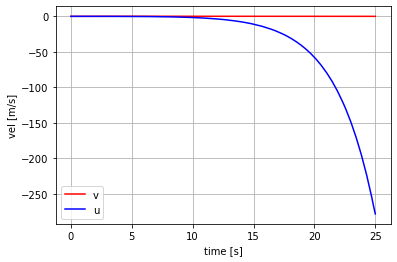

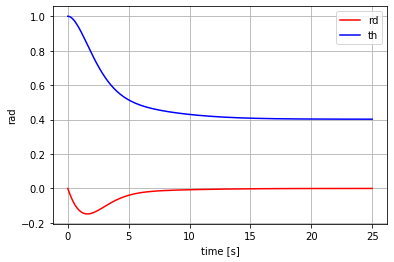

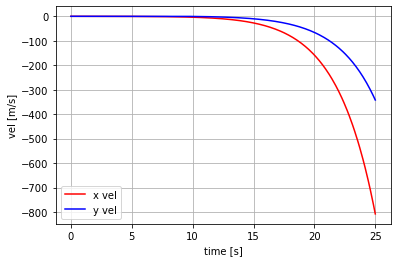

In [43]:
#wykres prędkości w lokalnym układzie sterowca
plt.figure()
plt.plot(t, v, 'r', label='v')
plt.plot(t, u, 'b', label='u')
plt.legend(loc='best')
plt.xlabel('time [s]')
plt.ylabel('vel [m/s]')
plt.grid(True)
plt.show()
#wykres wykres przyśpieszenia kątowego rd i prędkości kąta theta
plt.figure()
plt.plot(t, rd, 'r', label='rd')
plt.plot(t, ttad, 'b', label='th')
plt.legend(loc='best')
plt.xlabel('time [s]')
plt.ylabel('rad')
plt.grid(True)
plt.show()
#wykres prędkości w osi x i y układu globalnego 
plt.figure()
plt.plot(t, xd, 'r', label='x vel')
plt.plot(t, yd, 'b', label='y vel')
plt.legend(loc='best')
plt.xlabel('time [s]')
plt.ylabel('vel [m/s]')
plt.grid(True)
plt.show()